In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as datetime


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error  
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler


import matplotlib.pyplot as plt

import torch
from torch import nn
import numpy as np
from torch import optim
from PIL import Image
import torch.nn.functional as F
from torchvision import datasets, transforms, models

from torch.autograd import Variable

#Handle long operarations
# from workspace_utils import active_session

import argparse
import json

import h5py

from torchvision import datasets, transforms, models
from tqdm import tqdm

In [2]:
# Package to have access to the Zindi Platform features
!pip -q install git+https://github.com/eaedk/testing-zindi-package.git
from zindi.user import Zindian
#@title Input Username

# Login info for a Zindi Account

USERNAME = "Ebiendele" #@param {type : "string"}
# object
user = Zindian(username=USERNAME) # Sign in 
user.select_a_challenge(reward='all', kind='Competition', active='true')   
user.which_challenge                                    # Get information about the selected challenge
user.download_dataset(destination="dataset") # Download the dataset of the selected challenge

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
Your password
>> ··········

[ 🟢 ] 👋🏾👋🏾 Welcome Ebiendele 👋🏾👋🏾

__________________________________________________________________________________________________________________________________
|     |              |                  |                    |          
|index|  challenge   |     problem      |       reward       |    id    
|     |              |                  |                    |          
----------------------------------------------------------------------------------------------------------------------------------
|  0  |Public Compet |     Forecast     |    $17 000 USD     | rmb-cpi-nowcasting-challenge...
----------------------------------------------------------------------------------------------------------------------------------
|  1  |Public Compet |                  |    $10 000 USD     | africa-biomass-challenge...
--------------------------------------------------------

dataset/Baseline-Explained-English-Version.pdf: 100%|██████████| 96.8k/96.8k [00:00<00:00, 512ko/s]
dataset/Baseline_explained_French_Version.pdf: 100%|██████████| 105k/105k [00:00<00:00, 554ko/s] 
dataset/SampleSubmission.csv: 100%|██████████| 1.42k/1.42k [00:00<00:00, 1.18Mo/s]
dataset/UniqueID-SentinelPair.csv: 100%|██████████| 1.49k/1.49k [00:00<00:00, 1.00Mo/s]
dataset/ABC_dataset_report.pdf: 100%|██████████| 411k/411k [00:00<00:00, 1.09Mo/s]
dataset/images_test.h5: 100%|██████████| 311k/311k [00:00<00:00, 820ko/s]
dataset/GIZ_Biomass_Starter_Notebook.ipynb: 100%|██████████| 52.5k/52.5k [00:00<00:00, 553ko/s]
dataset/Training_Data_Collection_description.pdf: 100%|██████████| 835k/835k [00:00<00:00, 1.76Mo/s]
dataset/TestFiles.zip: 100%|██████████| 340k/340k [00:00<00:00, 913ko/s]
dataset/GIZ_Biomass_Starter_Notebook.zip: 100%|██████████| 18.6k/18.6k [00:00<00:00, 13.7Mo/s]
dataset/africa-biomass-challenge.zip: 100%|██████████| 2.05M/2.05M [00:00<00:00, 3.65Mo/s]


In [3]:
SEED = 3

#set all seeds
torch.manual_seed(SEED)
np.random.seed(SEED)

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
!unzip dataset/africa-biomass-challenge.zip -d "dataset/africa-biomass-challenge"  

Archive:  dataset/africa-biomass-challenge.zip
  inflating: dataset/africa-biomass-challenge/Baseline-Explained-English-Version.pdf  
  inflating: dataset/africa-biomass-challenge/Baseline_explained_French_Version.pdf  
  inflating: dataset/africa-biomass-challenge/SampleSubmission.csv  
  inflating: dataset/africa-biomass-challenge/UniqueID-SentinelPair.csv  
  inflating: dataset/africa-biomass-challenge/ABC_dataset_report.pdf  
  inflating: dataset/africa-biomass-challenge/images_test.h5  
  inflating: dataset/africa-biomass-challenge/GIZ_Biomass_Starter_Notebook.ipynb  
  inflating: dataset/africa-biomass-challenge/Training_Data_Collection_description.pdf  
  inflating: dataset/africa-biomass-challenge/TestFiles.zip  
  inflating: dataset/africa-biomass-challenge/GIZ_Biomass_Starter_Notebook.zip  


In [6]:
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [7]:
!wget -q  https://share.phys.ethz.ch/~pf/albecker/abc/09072022_1154_train.h5
!wget -q  https://share.phys.ethz.ch/~pf/albecker/abc/09072022_1154_val.h5
!wget -q https://share.phys.ethz.ch/~pf/albecker/abc/09072022_1154_test.h5

In [8]:
trainset = h5py.File("09072022_1154_train.h5", "r")
validateset = h5py.File("09072022_1154_val.h5", "r")
testset = h5py.File("09072022_1154_test.h5", "r")

In [9]:
# attributes of trainset
trainset.keys()

<KeysViewHDF5 ['agbd', 'cloud', 'images', 'lat', 'lon', 'scl']>

In [10]:
# train
train_images = np.array(trainset['images'],dtype=np.float64)
train_images = train_images.transpose(0,3,1,2)

train_biomasses = np.array(trainset['agbd'],dtype=np.float64)

# validate
validate_images = np.array(validateset['images'],dtype=np.float64)
validate_images = validate_images.transpose(0,3,1,2)
validate_biomasses = np.array(validateset['agbd'],dtype=np.float64)

# test 
test_images = np.array(testset['images'],dtype=np.float32)
test_images = test_images.transpose(0,3,1,2)
test_biomasses = np.array(testset['agbd'],dtype=np.float32)


print(f"train dataset size {train_images.shape} train lab size {train_biomasses.shape}")
print()
print(f"validate dataset size {validate_images.shape} validate lab size {validate_biomasses.shape}")
print()
print(f"test dataset size {test_images.shape} test lab size {test_biomasses.shape}")

train dataset size (25036, 12, 15, 15) train lab size (25036,)

validate dataset size (5174, 12, 15, 15) validate lab size (5174,)

test dataset size (5190, 12, 15, 15) test lab size (5190,)


<Axes: >

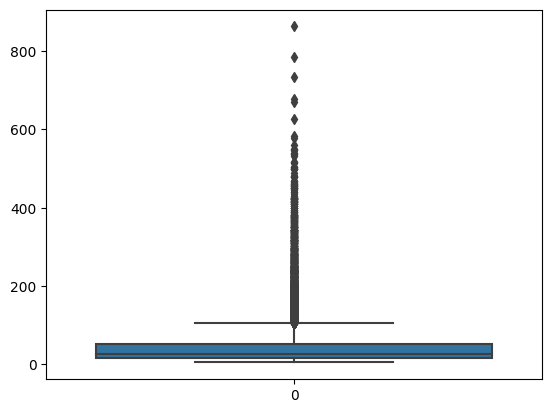

In [11]:
import seaborn as sns
sns.boxplot(train_biomasses)

In [12]:
# cite: https://stackoverflow.com/questions/35827863/remove-outliers-in-pandas-dataframe-using-percentiles
def cap_outliers(series, iqr_threshold=1.5, verbose=False):
    '''Caps outliers to closest existing value within threshold (IQR).'''
    
    series = pd.Series( series)
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1

    lbound = Q1 - iqr_threshold * IQR
    ubound = Q3 + iqr_threshold * IQR

    outliers = (series < lbound) | (series > ubound)

    series =  series.copy()
    series.loc[series < lbound] = series.loc[~outliers].min()
    series.loc[series > ubound] = series.loc[~outliers].max()
    
#     print(series)

    # For comparison purposes.
    if verbose:
            print('\n'.join(
                ['Capping outliers by the IQR method:',
                 f'   IQR threshold: {iqr_threshold}',
                 f'   Lower bound: {lbound}',
                 f'   Upper bound: {ubound}\n']))

    return series





<Axes: >

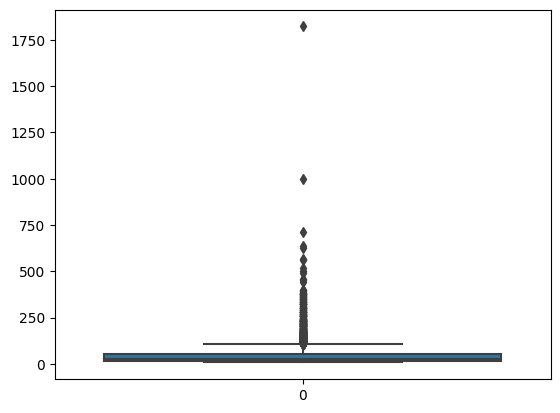

In [13]:
sns.boxplot(validate_biomasses)

<Axes: >

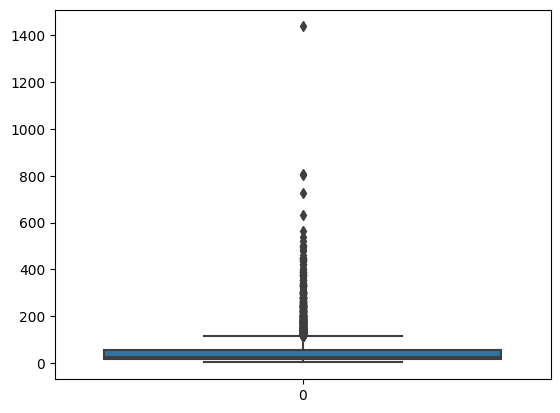

In [14]:
sns.boxplot(test_biomasses)

In [15]:
from torch.utils.data import TensorDataset, DataLoader, Dataset 

class CustomTensorDataset(Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]

        if self.transform:
            x = self.transform(x)

        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        return self.tensors[0].size(0)

# batch_size=1024
# batch_size=512
# batch_size=256
# batch_size=64
batch_size=32

train_images = torch.Tensor(train_images) # transform to torch tensor
# train_biomasses = torch.Tensor(train_biomasses)
train_biomasses = torch.Tensor(train_biomasses)



validate_images = torch.Tensor(validate_images) # transform to torch tensor
validate_biomasses = torch.Tensor(validate_biomasses) 

test_images = torch.Tensor(test_images) # transform to torch tensor
test_biomasses = torch.Tensor(test_biomasses)



# TODO: Define your transforms for the training, validation, and testing sets




 
train_transforms = transforms.Compose([
#                                         transforms.ToPILImage(),
                                      # transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(15),
# transforms.RandomHorizontalFlip(p=0.5),
                                      #  transforms.RandomHorizontalFlip(),
                                        # transforms.ToTensor(),
                                       transforms.RandomVerticalFlip(),
                                      #  transforms.Normalize( train_mean, train_std),
                                       

                                      #  transforms.ColorJitter( brightness=.05, saturation=0,
                                      #                         contrast=0), 
                                      #  transforms.RandomVerticalFlip(),
#                                       
#                                        transforms.Normalize(),
                     

# [ 234.8951,  276.7505,  325.3755,  285.8357,  413.4035,  902.8678,
#         1109.6798, 1111.2495, 1183.6342, 1166.2604,  691.2886,  441.2435])
]

)

valid_transforms = transforms.Compose([
#                                         transforms.ToPILImage(),
                                      # transforms.RandomRotation(30),
#                                        transforms.RandomResizedCrop(15),
                                      #  transforms.RandomHorizontalFlip(),
                                      #  transforms.RandomVerticalFlip(),
                                      #  transforms.ToTensor(),
#                                        transforms.Normalize(),
                                      # transforms.Normalize(  valid_mean, valid_std ),
]

)



test_transforms = transforms.Compose([
#                                         transforms.ToPILImage(),
                                      # transforms.RandomRotation(30),
#                                        transforms.RandomResizedCrop(15),
                                      #  transforms.RandomHorizontalFlip(),
                                      #  transforms.RandomVerticalFlip(),
                                      #  transforms.ToTensor(),
#                                        transforms.Normalize(),
                                      #  transforms.Normalize(  test_mean, test_std ),
]

)



train_dataset = CustomTensorDataset( tensors=(train_images,train_biomasses) , transform=train_transforms  
                                   ) # create your datset
train_dataloader = DataLoader(train_dataset, shuffle=True,batch_size=batch_size) # create your dataloader

 
valid_dataset = CustomTensorDataset(tensors=(validate_images,validate_biomasses), transform=valid_transforms 
                                   ) # create your datset
valid_dataloader = DataLoader(valid_dataset,shuffle=False,batch_size=batch_size) # create your dataloader
  
test_dataset = CustomTensorDataset(tensors=(test_images,test_biomasses), transform=test_transforms
                                  ) # create your datset
test_dataloader = DataLoader(test_dataset, shuffle=False,batch_size=batch_size) # create your dataloader
 
print(f"train dataset size {train_images.shape} train lab size {train_biomasses.shape}")
print()
print(f"validate dataset size {validate_images.shape} validate lab size {validate_biomasses.shape}")
print()
print(f"test dataset size {test_images.shape} test lab size {test_biomasses.shape}") 

train dataset size torch.Size([25036, 12, 15, 15]) train lab size torch.Size([25036])

validate dataset size torch.Size([5174, 12, 15, 15]) validate lab size torch.Size([5174])

test dataset size torch.Size([5190, 12, 15, 15]) test lab size torch.Size([5190])


In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [17]:
80 * 3 * 3

720

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
 

 #Added bath_normalisation + relu on every conv step


class Model(nn.Module):
    def __init__(self):
            super(Model, self).__init__()
            # self.conv1 = nn.Conv2d(12, 20, 3)
            # self.conv2 = nn.Conv2d(20, 40, 3)
            # self.conv3 = nn.Conv2d(40, 60, 3)
            # self.conv4 = nn.Conv2d(60, 80, 3)
            self.conv1 = nn.Conv2d(12, 10, 3)
            self.norm_conv1=nn.BatchNorm2d(10)

            self.conv2 = nn.Conv2d(10, 8, 3)
            self.norm_conv2=nn.BatchNorm2d(8)
            self.conv3 = nn.Conv2d(8, 6, 3)
            self.norm_conv3=nn.BatchNorm2d(6)
            self.conv4 = nn.Conv2d(6, 3, 3)
            self.norm_conv4=nn.BatchNorm2d(3)
            self.maxpool = nn.MaxPool2d(kernel_size=3, stride=1)
#             self.maxpool = nn.AvgPool2d(kernel_size=3, stride=1)
            
            


            self.flat = nn.Flatten(start_dim=0, end_dim=-1)
            
            # Bigger net
            self.fc1 = nn.Linear( 3* 3* 3, 2024)  
            self.norm_fc1=nn.BatchNorm1d(2024)
            self.fc2 = nn.Linear(2024, 1000)
            self.fc3 = nn.Linear(1000, 600)
            self.fc4 = nn.Linear(600, 200)
            self.fc5 = nn.Linear(200, 1) 

            #smaller net
            # self.fc1 = nn.Linear( 3* 3* 3, 1024)  
            # self.norm_fc1=nn.BatchNorm1d(1024)
            # self.fc2 = nn.Linear(1024, 512)
            # self.fc3 = nn.Linear(512, 256)
            # self.fc4 = nn.Linear(256, 128)
            # self.fc5 = nn.Linear(128, 1) 

            
            # self.dropout = nn.Dropout(0.15) # chnaged dropout from 0.1 to 0.2 
            self.dropout = nn.Dropout(0.10) 
 
        

    def forward(self, x):
#            x = torch.relu(self.conv1(x)) 
           x =  torch.relu( self.norm_conv1(  self.conv1(x)))
           x=self.maxpool(x)
          #  print(x.shape)
#            x = torch.relu(self.conv2(x))
           x =  torch.relu( self.norm_conv2( self.conv2(x)))
           x=self.maxpool(x)
          #  print(x.shape)
#            x = torch.relu(self.conv3(x))
           x =  torch.relu(self.norm_conv3(self.conv3(x)))
          #  print(x.shape) 
        
           x = torch.relu(self.norm_conv4(self.conv4(x)))

           
          #  print(x.shape)
        
#            x = x.view(x.size(0), 80 * 3 * 3)
           x = x.reshape(x.size(0),  3* 3* 3)
           print(x.shape)

        
           x =  torch.relu( self.norm_fc1(self.fc1(x)))
           x = self.dropout(x)
           x =  torch.relu(self.fc2(x))
           x = self.dropout(x)
           x =  torch.relu(self.fc3(x))
           x = self.dropout(x)
           x =  torch.relu(self.fc4(x))
           x = self.dropout(x)
  
           
           return torch.relu(self.fc5(x))

model = Model().to(device)
# print(model)

imgs = torch.rand(10, 12,15,15)

model(imgs.to(device))

torch.Size([10, 27])


tensor([[0.0000],
        [0.0264],
        [0.0248],
        [0.0126],
        [0.0422],
        [0.0006],
        [0.0000],
        [0.0066],
        [0.0000],
        [0.0394]], grad_fn=<ReluBackward0>)

In [19]:
orig_pre_model =  models.resnet101(pretrained=True)

# Freeze parameters so we don't backpropagate through them
for param in model.parameters():
    param.requires_grad = False


class Model(nn.Module):
    def __init__(self, model):
            super(Model, self).__init__()
  
            
            # initialize_weights(self.modules())
            self.trained = model 
#             pretrained_weights = self.trained.conv1.weight.clone()


            self.trained.conv1 = nn.Conv2d(12, 64, kernel_size=7, stride=2, padding=3,bias=False)

            # res.conv1.weight[:,:3,:,:] = torch.nn.Parameter(pretrained_weights)
            # res.conv1.weight[:,3,:,:] = torch.nn.Parameter(pretrained_weights[:,1,:,:])
 

            self.frontend = nn.Sequential(
                self.trained.conv1, self.trained.bn1, self.trained.relu, self.trained.maxpool,
                 self.trained.layer1, self.trained.layer2
            ) 
 

            
            # Bigger net
            # self.fc1 = nn.Linear(  512*2*2, 2024)  
            # self.norm_fc1=nn.BatchNorm1d(2024)
            # self.fc2 = nn.Linear(2024, 1000)
            # self.fc3 = nn.Linear(1000, 600)
            # self.fc4 = nn.Linear(600, 200)
            # self.fc5 = nn.Linear(200, 1) 
            self.drop_rate = 0.6
            self.FC = nn.Sequential(
               nn.Linear(  512*2*2, 4096)  , nn.BatchNorm1d(4096), nn.ReLU(), nn.Dropout(self.drop_rate) ,  
               nn.Linear(  4096,  4096)  , nn.BatchNorm1d(4096), nn.ReLU(), nn.Dropout(self.drop_rate) ,  
                nn.Linear( 4096, 2024)  ,    nn.BatchNorm1d(2024), nn.ReLU(), nn.Dropout(self.drop_rate) ,   
                nn.Linear(2024, 1000) ,    nn.BatchNorm1d(1000), nn.ReLU(),nn.Dropout(self.drop_rate) ,  
                nn.Linear(1000, 600),   nn.BatchNorm1d(600), nn.ReLU(),nn.Dropout(self.drop_rate) , 
                nn.Linear(600, 250) ,nn.BatchNorm1d(250),  nn.ReLU(), nn.Dropout(self.drop_rate) ,
                nn.Linear(250, 1),nn.ReLU()  


            ) 





 
            
            # self.dropout = nn.Dropout(0.15) # chnaged dropout from 0.1 to 0.2 
            # self.dropout = nn.Dropout(0.10) 
 
        

    def forward(self, x):
#            x = torch.relu(self.conv1(x)) 
           x = self.frontend(x)
#            x=self.maxpool(x)
          #  print(x.shape)  

           x = x.reshape(x.size(0),  512*2*2)
          #  print(x.shape)

           x =  self.FC(x)

      
  
           
           return x

model = Model(orig_pre_model).to(device)
# print(model1)

imgs = torch.rand(10, 12,15,15)

model(imgs.to(device))

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:01<00:00, 179MB/s]


tensor([[0.0000],
        [0.3828],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.2350],
        [0.0000],
        [0.0000],
        [0.0000]], grad_fn=<ReluBackward0>)

In [20]:
from sklearn.metrics import mean_squared_error
def check_acc( loader, model, device,loss_fn ):
  loss = 0 
  model.eval() 
  with torch.inference_mode():
    for x,y in loader:
      x = x.to(device).to(torch.float32)
      y = y.to(torch.float).unsqueeze(1)

      valid_outputs = model(x)

      valid_loss =  loss_fn(valid_outputs, y.unsqueeze(1)) 
      
      loss +=valid_loss.item()

  
  model.train()
  print(f'Valid:Loss function: {loss/len(loader)}')  
  return loss/len(loader)

 


def save_checkpoint(state, filename):
  print('---> Saving checkpoint')
  torch.save(state, filename)

def load_checkpoint(checkpoint, model):
  print('---> Loading checkpoint')
  model.load_state_dict( checkpoint['state_dict']) 


def train_fn(loader, model, optimizer, loss_fn, device):
      loss_t = 0 
   
      for x,y in loader:
          x = x.to(device).to(torch.float32)
          y = y.to(torch.float).unsqueeze(1).to(device) 

          preds = model(x).to(torch.float) 

          loss = loss_fn(   preds, y )
          loss_t += loss.item()


           
          optimizer.zero_grad()

          loss.backward()

          optimizer.step() 

      print(f'Train:Loss function: { loss_t/len(loader)}')  

In [24]:

model_path = "/content/dataset"

In [ ]:
from tqdm.auto import tqdm
import pandas as pd
import torch.optim as optim

model = Model(orig_pre_model).to(device)
# print(model)
 

# optimizer = optim.Adam(model.parameters(), lr=3e-4)
# optimizer = optim.Adam(model.parameters(), lr=0.0003) #lr=0.0003 --> lr=0.003

# optimizer = optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False, 
#                         maximize=False, foreach=None, capturable=False)
optimizer = optim.AdamW(model.parameters(), lr=0.0003, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.001, amsgrad=False, 
                        maximize=False, foreach=None, capturable=False)
# loss_fn =nn.L1Loss()
loss_fn = nn.MSELoss() 

epochs= 100 #50 #60
print_every =10000
running_loss = 0 



training_loss = []
validation_loss = []
epoch_list = []

 

seedlist = [0,1,2,3,4,5]
# seedlist = [2]
predictions_dict = {0:[],1:[],2:[],3:[],4:[],5:[],6:[],7:[],8:[],9:[]}

globall_loss = 999999999

# for seed in seedlist: #Ensample based on seed
seed = 4
torch.manual_seed(seed)
np.random.seed(seed)
 
      
for epoch in tqdm(range(epochs)):        

    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data
        inputs, labels  = inputs.to(device), labels.to(device) 


        # Compute the forward pass
        outputs = model(inputs)

        # Compute the loss function
        loss = loss_fn(outputs, labels.unsqueeze(1))
        running_loss += loss.item() 

        #Zero grad
        optimizer.zero_grad()
        # Compute the gradients
        loss.backward()

        # Update the weights
        optimizer.step()  

        if (i%print_every == 0):
            
            #Initialise some stats data
            valid_loss_acc = 0
            
            model.eval() 
            with torch.inference_mode():
                    for index2,data in enumerate(valid_dataloader, 0):
                        inputs, labels = data

                        inputs, labels = inputs.to(device), labels.to(device) 

                        # Compute the forward pass
                        valid_outputs = model(inputs)

                        # Compute the loss function
                        valid_loss =  loss_fn(valid_outputs, labels.unsqueeze(1)) 
                        
                        valid_loss_acc += valid_loss.item()
 

#             print(f'epoch:{epoch} i={i}|Loss {loss.item():.4f} Valid loss:{valid_loss:.4f}' )
            
            print(f"Epoch {epoch+1}/{epochs} seed={seed}.. "
                    f"Train loss: {(running_loss/print_every):.3f}.. "
                    f"Valid loss: { (valid_loss_acc/len(valid_dataloader)):.3f}.. "
                     f"Best so far ... : { globall_loss :.3f}.. "  )
            
            if ((valid_loss_acc/len(valid_dataloader)) < globall_loss) : 
                  globall_loss = (valid_loss_acc/len(valid_dataloader))
                  es = 0 
                  checkpoint = {
                      'state_dict' : model.state_dict(), 
                      'optimizer':  optimizer.state_dict(), 
                  }
                  save_checkpoint(checkpoint, filename=model_path +str(seed)+'_checkpoint_small.pth')
            else:
                es +=1  
            if es == 3:
                break 
            
            training_loss.append(running_loss/print_every )
            validation_loss.append(valid_loss_acc/len(valid_dataloader))
            epoch_list.append(epoch)



            running_loss = 0
            model.train()  
            
     

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100 seed=4.. Train loss: 0.259.. Valid loss: 6319.823.. Best so far ... : 999999999.000.. 
---> Saving checkpoint
Epoch 2/100 seed=4.. Train loss: 344.451.. Valid loss: 4517.589.. Best so far ... : 6319.823.. 
---> Saving checkpoint
Epoch 3/100 seed=4.. Train loss: 269.528.. Valid loss: 4198.205.. Best so far ... : 4517.589.. 
---> Saving checkpoint


In [ ]:
df1= pd.DataFrame(predictions_dict)
df1
import pandas as pd
df1= pd.read_csv('ensamples_3.csv')
# 1, 2, 3**, 4*, 6* , 7*, 8*

In [ ]:
df1 = df1.iloc[:, 1:]
df1

In [ ]:
plt.figure(figsize=(12, 6))
plt.scatter(epoch_list[5:], training_loss[5:], label="Train Error")
# plt.scatter(epoch_list, train_acc_list, label="Train Accuracy")
plt.scatter(epoch_list[5:], validation_loss[5:], label="Test Error")
# plt.scatter(epoch_list, test_acc_list, label="Test Accuracy")
plt.legend()
plt.show()


In [ ]:
import pandas as pd
# 10,8,7,5 , 4 3 , 1 , 0
# 5.  41.  89. -- Done. 62
# 4.  59.  82. -- Done. 57
# 3 42.  100.  -- Done 58
# 1.  44.  85  -- Done
# 0. 40. 45 
load_checkpoint( torch.load(model_path +'4_checkpoint_small.pth',  map_location=torch.device('cpu')), model)
s2_images_h5 = h5py.File("images_test.h5", "r")

#prepare test set sentinel 2 images 
s2_images = np.array(s2_images_h5["images"])
s2_images = s2_images.transpose(0,3,1,2)

 
s2_images = torch.Tensor(s2_images.astype(float)) 
dummy_labels =   torch.zeros(90, 1) 

s2_dataset = CustomTensorDataset( tensors=(s2_images,dummy_labels) , transform = test_transforms) # create your datset

s2_dataloader = DataLoader(s2_dataset, shuffle=False,batch_size=len(s2_dataset)) # create your dataloader

model.eval()
pred_giz = None

with torch.inference_mode():
    for batch, _ in s2_dataloader:
#         print(batch )
        pred_giz=model(batch.to(device)) 
    

pred_giz = pred_giz.squeeze().cpu().numpy()    
# s2_means, s2_stds = get_mean_std(s2_dataloader)
# s2_means, s2_stds
 
# pred_giz = model(s2_images)
# pred_giz = pred_giz.squeeze().detach().numpy()

 
ID_S2_pair = pd.read_csv('/content/dataset/UniqueID-SentinelPair.csv')

preds = pd.DataFrame({'Target':pred_giz}).rename_axis('S2_idx').reset_index()
preds = ID_S2_pair.merge(preds, on='S2_idx').drop(columns=['S2_idx'])

# preds['Target'] = preds['Target']/1000 26, 63
# preds
# preds.to_csv('4nrm2e100b128.csv', index=False)
preds.to_csv('RnetDrop556.csv', index=False)

# *********?Summary
#HFlip - does no help
#Test VFlip - Imporoves --- : 62.14 on LB
#Test increasing droput 0.1 -> 0.15 :  



preds


# 2. 40 75
#.4    27.   81
# 32 75